# Clasificación

In [1]:
import contextily as ctx
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

## $X$: Otus, $y$: city

In [2]:
carpeta_data = "data"
nombre_archivo = "reduced_otus_rf100.csv"

# Obtén la ruta absoluta de la carpeta actual
ruta_actual = os.getcwd()
# Construye la ruta completa al archivo CSV dentro de la carpeta "data"
ruta_archivo = os.path.join(ruta_actual, carpeta_data, nombre_archivo)
otus = pd.read_csv(ruta_archivo, index_col="ID")

cont_names = list(otus.drop(["ID_city","City","Climate","Latitude", "Longitude","Year"], axis=1).columns)
y_names = ["ID_city"]
otus_df = otus[cont_names+y_names]
otus_df.shape

(365, 101)

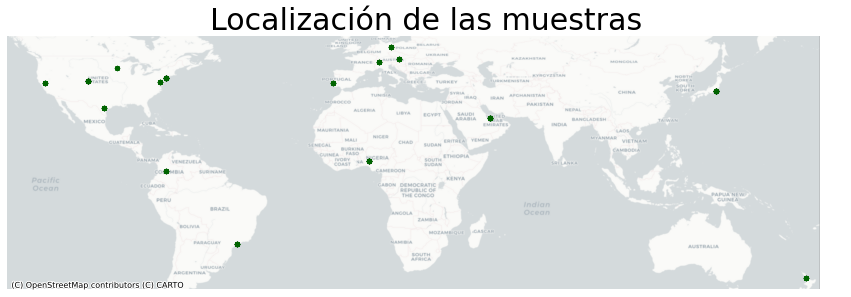

In [3]:
otus_gdf = gpd.GeoDataFrame(otus.copy(), geometry=gpd.points_from_xy(otus['Longitude'], otus['Latitude']), crs='EPSG:4326')

fig, ax = plt.subplots(1, figsize=(15, 15))
otus_gdf.plot(marker='.', c='darkgreen', ax=ax, markersize=70, zorder=1)
plt.title("Localización de las muestras",fontsize=30)
plt.axis("off")
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='EPSG:4326')

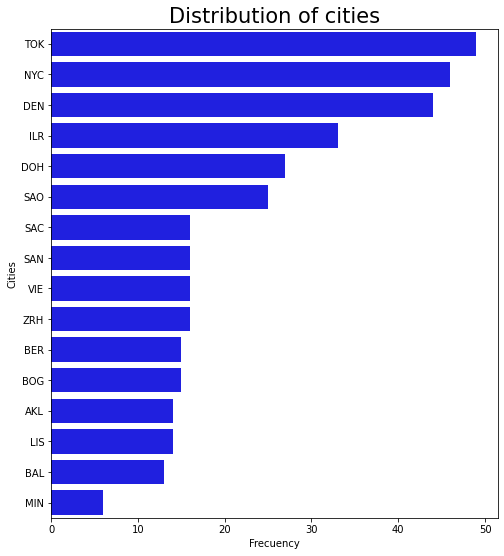

In [5]:
fig, ax = plt.subplots(1,1 ,figsize=(8, 9))
sns.countplot(data=otus_df, y="ID_city", order=otus_df.ID_city.value_counts().index, color="blue")
plt.xlabel("Frecuency")
plt.ylabel("Cities")
plt.title("Distribution of cities", fontsize=21)
plt.show()

In [10]:
#y_counts = otus_df.ID_city.value_counts()
#y_counts

In [6]:
from sklearn.preprocessing import LabelEncoder
from camda_functions import split_stratified_into_train_val_test

In [7]:
#X = np.array(otus_df.drop(y_names,axis=1)).astype('float')
X = otus_df.drop(y_names,axis=1).astype('float')
y = np.array(otus_df[y_names]).ravel()
# categorización de la respuesta
le = LabelEncoder()
le.fit(y)
#le.classes_
y_cat = le.transform(y)
#le.inverse_transform(y_cat[:5])

# create train (70%), validation (20%) and test (10%) datasets
X_train, y_train, X_val, y_val, X_test, y_test, class_w, __ = \
    split_stratified_into_train_val_test(X, y_cat, .70, .10, .20, std=True, two_subsets=True)

In [8]:
X_train.shape

(291, 100)

### Random forests (baseline)

In [9]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

n_trees = 800
rf = RandomForestClassifier(n_estimators=n_trees, min_samples_split=3, oob_score=True, n_jobs=-1, random_state=42)
rf.fit(X_train,y_train)
# predecir datos de validacion
y_test_hat = rf.predict(X_test)

print(metrics.classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.00      0.00      0.00         3
           2       0.67      0.67      0.67         3
           3       1.00      0.33      0.50         3
           4       0.56      1.00      0.72         9
           5       1.00      0.33      0.50         6
           6       0.50      0.86      0.63         7
           7       1.00      0.33      0.50         3
           8       0.00      0.00      0.00         1
           9       0.47      0.89      0.62         9
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         3
          12       0.38      0.60      0.46         5
          13       0.70      0.70      0.70        10
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         3

    accuracy                           0.54        74
   macro avg       0.42   

/home/victor/virtualenv/deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/victor/virtualenv/deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/victor/virtualenv/deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### XGBoost

In [10]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier

parameters = {
    'max_depth': [2, 5, 10],
    'n_estimators': [100,200,500],
    'eta': [0.5, 0.3, 0.1]
}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

grid_search = GridSearchCV(
    estimator=XGBClassifier(objective="multi:softprob", seed=42, verbosity=1),
    param_grid=parameters,
    scoring = 'f1_macro',
    n_jobs = -1,
    cv = kfold,
    verbose=True
)


In [11]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=7, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob', predictor=None, ...),
             n_jobs=-1,
             param_grid={'eta': [0.5, 0.3, 0.1], 'max_depth': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='f1_macro', verbose=True)

In [12]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

Best: 0.482094 using {'eta': 0.3, 'max_depth': 2, 'n_estimators': 500}


In [13]:
xgb_best = grid_search.best_estimator_
xgb_best.fit(X_train, y_train)
res = xgb_best.predict(X_test)
print(metrics.classification_report(y_test, res))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.33      0.33      0.33         3
           2       1.00      0.67      0.80         3
           3       0.33      0.33      0.33         3
           4       0.67      0.89      0.76         9
           5       0.75      0.50      0.60         6
           6       0.75      0.86      0.80         7
           7       1.00      0.33      0.50         3
           8       0.00      0.00      0.00         1
           9       0.58      0.78      0.67         9
          10       0.33      0.33      0.33         3
          11       1.00      0.33      0.50         3
          12       0.30      0.60      0.40         5
          13       0.64      0.70      0.67        10
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         3

    accuracy                           0.57        74
   macro avg       0.51   

/home/victor/virtualenv/deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/victor/virtualenv/deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/victor/virtualenv/deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## $X$: Genes, $y$: city

In [108]:
carpeta_data = "data"
nombre_archivo = "amr-counts_card_info_20230604.tsv"
# Obtén la ruta absoluta de la carpeta actual
ruta_actual = os.getcwd()
# Construye la ruta completa al archivo CSV dentro de la carpeta "data"
ruta_archivo = os.path.join(ruta_actual, carpeta_data, nombre_archivo)
temp_data = pd.read_table(ruta_archivo, delimiter="\t")
names_to_drop = ["name","ARO","ARO_Trace","Aro_name_trace","family", "drugClass","mechanism"]
genes_data = pd.DataFrame(temp_data.drop(names_to_drop, axis=1).transpose())
genes_data.columns = temp_data['ARO']
#genes_data

In [109]:
from camda_functions import get_tfidf, load_from_pickle

In [110]:
# cargar un modelo de factorización de matrices sparse ya entrenado
f_path = os.path.join(ruta_actual, carpeta_data)
pkl_file = 'nmf.pkl'
nmf_model = load_from_pickle(f_path, pkl_file)

tfidf = get_tfidf(genes_data)
lsa_genes = nmf_model.transform(tfidf)
lsa_genes.shape

(365, 150)

In [111]:
lsa_genes

array([[2.82498365e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.50072344e-03, 1.39766199e-01, 2.42880283e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.26342275e-02, 2.77424188e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.66192525e-02, 0.00000000e+00, 4.37743329e-04, ...,
        0.00000000e+00, 9.00517414e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.74527994e-03, 0.00000000e+00, 0.00000000e+00],
       [2.72233763e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [112]:
otus_y = otus["ID_city"]

In [113]:
latent_names = [f"t {i}" for i in range(lsa_genes.shape[1])]
otus_y = otus["ID_city"]
lsa_df = pd.DataFrame(lsa_genes, index=genes_data.index, columns=latent_names)
# junto las tablas de genes y otus, solo para estar seguro de que tienen las mismas observaciones
lsa_city = lsa_df.join(otus_y, how="inner")

In [114]:
#X = np.array(otus_df.drop(y_names,axis=1)).astype('float')
X = lsa_city.drop("ID_city",axis=1).astype('float')
y = np.array(lsa_city[y_names]).ravel()
# categorización de la respuesta
le = LabelEncoder()
le.fit(y)
#le.classes_
y_cat = le.transform(y)
#le.inverse_transform(y_cat[:5])

# create train (70%), validation (20%) and test (10%) datasets
X_train, y_train, X_val, y_val, X_test, y_test, class_w, __ = \
    split_stratified_into_train_val_test(X, y_cat, .70, .10, .20, std=True, two_subsets=True)

### Random forests (baseline)

In [46]:
n_trees = 500
rf = RandomForestClassifier(n_estimators=n_trees, min_samples_split=3, oob_score=True, n_jobs=-1, random_state=42)
rf.fit(X_train,y_train)
# predecir datos de validacion
y_test_hat = rf.predict(X_test)

print(metrics.classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      0.33      0.50         3
           2       0.00      0.00      0.00         3
           3       1.00      1.00      1.00         3
           4       0.27      0.67      0.39         9
           5       0.00      0.00      0.00         6
           6       0.70      1.00      0.82         7
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         1
           9       0.47      0.78      0.58         9
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         3
          12       0.40      0.40      0.40         5
          13       0.50      0.70      0.58        10
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         3

    accuracy                           0.47        74
   macro avg       0.33   

/home/victor/virtualenv/deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/victor/virtualenv/deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/victor/virtualenv/deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


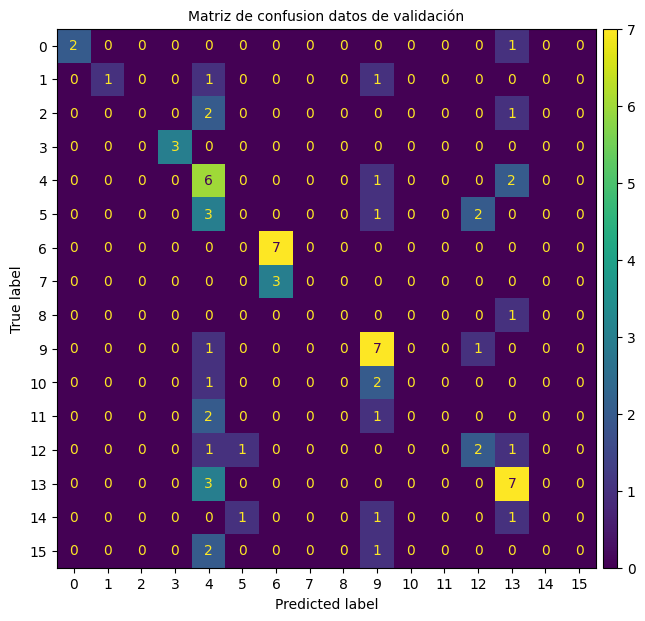

In [47]:
plt.style.use('default') 
cm = metrics.confusion_matrix(y_test, y_test_hat, normalize=None)
disp1 = metrics.ConfusionMatrixDisplay(cm, display_labels=np.arange(len(le.classes_)))
fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Matriz de confusion datos de validación',{'fontsize':10})

disp1.plot(ax=ax, colorbar=False)
# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(disp1.im_,  cax=cax);

### XGBoost

In [115]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier

parameters = {
    'max_depth': [2, 5, 10],
    'n_estimators': [100,200,500],
    'eta': [0.5, 0.3, 0.1]
}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

grid_search = GridSearchCV(
    estimator=XGBClassifier(objective="multi:softprob", seed=42, verbosity=1),
    param_grid=parameters,
    scoring = 'f1_macro',
    n_jobs = -1,
    cv = kfold,
    verbose=True
)


In [116]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=7, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob', predictor=None, ...),
             n_jobs=-1,
             param_grid={'eta': [0.5, 0.3, 0.1], 'max_depth': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='f1_macro', verbose=True)

In [117]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

Best: 0.317027 using {'eta': 0.3, 'max_depth': 5, 'n_estimators': 200}


In [118]:
xgb_best = grid_search.best_estimator_
xgb_best.fit(X_train, y_train)
res = xgb_best.predict(X_test)
print(metrics.classification_report(y_test, res))

              precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.50      0.67      0.57         3
           2       0.00      0.00      0.00         3
           3       1.00      0.67      0.80         3
           4       0.40      0.67      0.50         9
           5       0.00      0.00      0.00         6
           6       1.00      0.43      0.60         7
           7       0.33      0.33      0.33         3
           8       0.00      0.00      0.00         1
           9       0.50      0.44      0.47         9
          10       0.33      0.33      0.33         3
          11       0.00      0.00      0.00         3
          12       0.14      0.20      0.17         5
          13       0.31      0.50      0.38        10
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         3

    accuracy                           0.36        74
   macro avg       0.31   

/home/victor/virtualenv/deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/victor/virtualenv/deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/victor/virtualenv/deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## $X$: OTUS + Genes, $y$: city

In [108]:
carpeta_data = "data"
nombre_archivo = "amr-counts_card_info_20230604.tsv"
# Obtén la ruta absoluta de la carpeta actual
ruta_actual = os.getcwd()
# Construye la ruta completa al archivo CSV dentro de la carpeta "data"
ruta_archivo = os.path.join(ruta_actual, carpeta_data, nombre_archivo)
temp_data = pd.read_table(ruta_archivo, delimiter="\t")
names_to_drop = ["name","ARO","ARO_Trace","Aro_name_trace","family", "drugClass","mechanism"]
genes_data = pd.DataFrame(temp_data.drop(names_to_drop, axis=1).transpose())
genes_data.columns = temp_data['ARO']
#genes_data

In [109]:
from camda_functions import get_tfidf, load_from_pickle

In [110]:
# cargar un modelo de factorización de matrices sparse ya entrenado
f_path = os.path.join(ruta_actual, carpeta_data)
pkl_file = 'nmf.pkl'
nmf_model = load_from_pickle(f_path, pkl_file)

tfidf = get_tfidf(genes_data)
lsa_genes = nmf_model.transform(tfidf)
lsa_genes.shape

(365, 150)

In [111]:
lsa_genes

array([[2.82498365e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.50072344e-03, 1.39766199e-01, 2.42880283e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.26342275e-02, 2.77424188e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.66192525e-02, 0.00000000e+00, 4.37743329e-04, ...,
        0.00000000e+00, 9.00517414e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.74527994e-03, 0.00000000e+00, 0.00000000e+00],
       [2.72233763e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [112]:
otus_y = otus["ID_city"]

In [123]:
#X = np.array(otus_df.drop(y_names,axis=1)).astype('float')
X2 = otus_df.drop(y_names,axis=1).astype('float')

In [126]:
latent_names = [f"t {i}" for i in range(lsa_genes.shape[1])]
otus_y = otus["ID_city"]
lsa_df = pd.DataFrame(lsa_genes, index=genes_data.index, columns=latent_names)
# junto las tablas de genes y otus
genes_otus = lsa_df.join(X2, how="inner")
genes_otus = genes_otus.join(otus_y, how="inner")
genes_otus

,t 0,t 1,t 2,t 3,t 4,t 5,t 6,t 7,t 8,t 9,...,X2170046,X675060,X1655646,X10660,X2956583,X2746926,X2169857,X2956349,X2025397,ID_city
CAMDA23_MetaSUB_gCSD16_AKL_1,0.002825,0.000000,0.000000,0.000000,0.000000,0.000000,0.271512,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AKL
CAMDA23_MetaSUB_gCSD16_AKL_10,0.008501,0.139766,0.000243,0.071551,0.002660,0.002425,0.113093,0.002001,0.00000,0.001566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AKL
CAMDA23_MetaSUB_gCSD16_AKL_11,0.082634,0.277424,0.000000,0.003612,0.000000,0.000128,0.000000,0.000000,0.00031,0.000008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AKL
CAMDA23_MetaSUB_gCSD16_AKL_12,0.000000,0.001469,0.117031,0.000000,0.202132,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AKL
CAMDA23_MetaSUB_gCSD16_AKL_13,0.066484,0.000000,0.000000,0.000000,0.008551,0.000000,0.000000,0.000446,0.00000,0.000494,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AKL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAMDA23_MetaSUB_gCSD17_ZRH_5,0.011935,0.007830,0.000786,0.000000,0.000000,0.000000,0.012627,0.000000,0.00000,0.010112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZRH
CAMDA23_MetaSUB_gCSD17_ZRH_6,0.095482,0.000000,0.000119,0.000000,0.000000,0.000000,0.000112,0.000000,0.00000,0.013616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZRH
CAMDA23_MetaSUB_gCSD17_ZRH_7,0.096619,0.000000,0.000438,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.002512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZRH
CAMDA23_MetaSUB_gCSD17_ZRH_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.002130,0.000000,0.000000,0.00000,0.006866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZRH


In [127]:
#X = np.array(otus_df.drop(y_names,axis=1)).astype('float')
X = genes_otus.drop("ID_city",axis=1).astype('float')
y = np.array(genes_otus[y_names]).ravel()
# categorización de la respuesta
le = LabelEncoder()
le.fit(y)
#le.classes_
y_cat = le.transform(y)
#le.inverse_transform(y_cat[:5])

# create train (70%), validation (20%) and test (10%) datasets
X_train, y_train, X_val, y_val, X_test, y_test, class_w, __ = \
    split_stratified_into_train_val_test(X, y_cat, .70, .10, .20, std=True, two_subsets=True)

### Random forests (baseline)

In [128]:
n_trees = 500
rf = RandomForestClassifier(n_estimators=n_trees, min_samples_split=3, oob_score=True, n_jobs=-1, random_state=42)
rf.fit(X_train,y_train)
# predecir datos de validacion
y_test_hat = rf.predict(X_test)

print(metrics.classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         3
           2       0.50      1.00      0.67         3
           3       1.00      1.00      1.00         3
           4       0.75      1.00      0.86         9
           5       0.60      0.50      0.55         6
           6       0.71      0.71      0.71         7
           7       0.50      0.67      0.57         3
           8       0.00      0.00      0.00         1
           9       0.60      1.00      0.75         9
          10       1.00      0.67      0.80         3
          11       1.00      0.33      0.50         3
          12       0.80      0.80      0.80         5
          13       0.71      1.00      0.83        10
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         3

    accuracy                           0.69        74
   macro avg       0.51   

/home/victor/virtualenv/deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/victor/virtualenv/deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/victor/virtualenv/deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


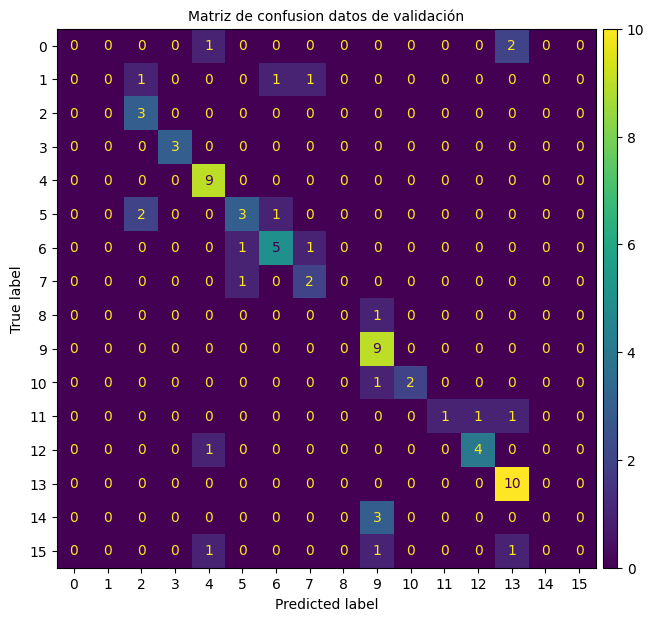

In [129]:
plt.style.use('default') 
cm = metrics.confusion_matrix(y_test, y_test_hat, normalize=None)
disp1 = metrics.ConfusionMatrixDisplay(cm, display_labels=np.arange(len(le.classes_)))
fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Matriz de confusion datos de validación',{'fontsize':10})

disp1.plot(ax=ax, colorbar=False)
# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(disp1.im_,  cax=cax);

### XGBoost

In [130]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier

parameters = {
    'max_depth': [2, 5, 10],
    'n_estimators': [100,200,500],
    'eta': [0.5, 0.3, 0.1]
}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

grid_search = GridSearchCV(
    estimator=XGBClassifier(objective="multi:softprob", seed=42, verbosity=1),
    param_grid=parameters,
    scoring = 'f1_macro',
    n_jobs = -1,
    cv = kfold,
    verbose=True
)


In [131]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=7, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob', predictor=None, ...),
             n_jobs=-1,
             param_grid={'eta': [0.5, 0.3, 0.1], 'max_depth': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='f1_macro', verbose=True)

In [132]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

Best: 0.495445 using {'eta': 0.3, 'max_depth': 2, 'n_estimators': 200}


In [133]:
xgb_best = grid_search.best_estimator_
xgb_best.fit(X_train, y_train)
res = xgb_best.predict(X_test)
print(metrics.classification_report(y_test, res))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.67      0.67      0.67         3
           2       0.60      1.00      0.75         3
           3       1.00      1.00      1.00         3
           4       0.75      1.00      0.86         9
           5       1.00      0.50      0.67         6
           6       1.00      0.71      0.83         7
           7       0.50      0.67      0.57         3
           8       1.00      1.00      1.00         1
           9       0.64      1.00      0.78         9
          10       1.00      0.33      0.50         3
          11       1.00      0.67      0.80         3
          12       0.83      1.00      0.91         5
          13       0.75      0.90      0.82        10
          14       0.50      0.33      0.40         3
          15       0.00      0.00      0.00         3

    accuracy                           0.74        74
   macro avg       0.70   

/home/victor/virtualenv/deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/victor/virtualenv/deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/victor/virtualenv/deep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
